# Transfer Learning
적은 데이터 만으로 모델을 학습 하기 힘들때 __미리 학습한 딥러닝 모델(Pre-Trained Model)__ 로 __재학습(Fine-tuning)__ 시키는 방법을 사용하며, 이를 **전이학습(Transfer Learning)** 이라한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
BATCH_SIZE = 32
EPOCHS = 10

In [8]:
# 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 불러오기
data_transforms = {
    'train' : transforms.Compose([                            # Compose 안의 과정을 거친 후 데이터 로드
        transforms.RandomResizedCrop(224),                    # 이미지 내 랜덤으로 선택해 224사이즈로 변경
        transforms.RandomHorizontalFlip(),                    # 50%로 좌우 반전
        transforms.ToTensor(),                                # 0~1 사이로 정규화
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])# 또다시 정규화를 진행하며 red, green, blue 순으로 평균을 0.5씩 적용
    ]),
    'val' : transforms.Compose([                              # 
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder('./data/hymenoptera_data', data_transforms[x]) for x in ['train', 'val']}   # 데이터 불러오고 전처리 적용
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=BATCH_SIZE,
                                             num_workers = 0,
                                             shuffle = True) for x in ['train', 'val']}

In [10]:
# 데이터 확인
for (x_train, y_train) in dataloaders['train']:
    print('x_train : ', x_train.size(), 'type : ', x_train.type())
    print('y_train : ', y_train.size(), 'type : ', y_train.type())
    break

x_train :  torch.Size([32, 3, 224, 224]) type :  torch.FloatTensor
y_train :  torch.Size([32]) type :  torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

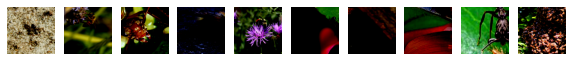

In [14]:
# 데이터 출력
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
    #plt.title('Class : ', str(y_train[i].item()))

In [15]:
# 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=  image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('train Epoch : {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [16]:
# 학습 과정에서 모델 성능 확인하는 함수 정의
def evaluagte(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_oss, test_accuracy

In [18]:
# 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정
import torchvision.models as models
model = models.resnet18(pretrained = False)  # 모델만 가져오고 파라미터는 랜덤으로
num_ftrs = model.fc.in_features              # 레이어의 input에 해당하는 노드 수
model.fc = nn.Linear(num_ftrs, 2)              # output을 2개로 설정(개미, 벌)

In [19]:
# 옵티마이저와 손실함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 미리 학습되지 않은 ResNet18 학습을 실행해 Train, Tet set의 Loss 및 Test set Accuracy 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders['train'], optimizer, log_interval=5)
    test_loss, test_accuracy = evaluate(model, dataloaders['val'])
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy: {:.2f} %\n'.format(Epoch, test_loss, test_accuracy))